**This implementation is based of https://people.duke.edu/~charvey/Teaching/BA453_2006/Idzorek_onBL.pdf**

This will only work in collab.


In [16]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt
import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
    os.chdir('PyPortfolioOpt/cookbook')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

In [17]:
tickers = ["TWO", "FSK", "AJX", "OFG", "CMRE", "HNRG", "SALM", "DHT", "AGNC", "GME", "ACR", "DX", "BGFV", "BPOP", "LUMN"]
prices = yf.download(tickers, start="2018-01-01", end="2024-03-01")['Adj Close'] #give date
prices.tail()
market_prices = yf.download("SPY", period="max")["Adj Close"] #baseline We might change this depending on the tickers
market_prices.head()
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
#caps

[*********************100%%**********************]  15 of 15 completed
[*********************100%%**********************]  1 of 1 completed


**We have now loaded our data**



<Axes: xlabel='Ticker', ylabel='Ticker'>

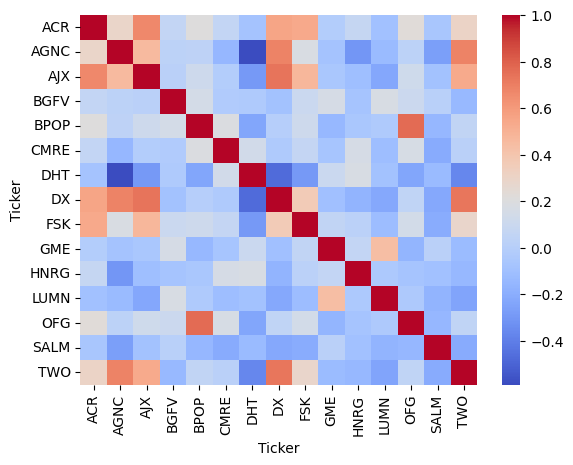

In [18]:
import pypfopt
pypfopt.__version__
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta
#Visualize the Covariant Correlation
sns.heatmap(S.corr(), cmap='coolwarm')

**We now retrieve the correlation matrix**

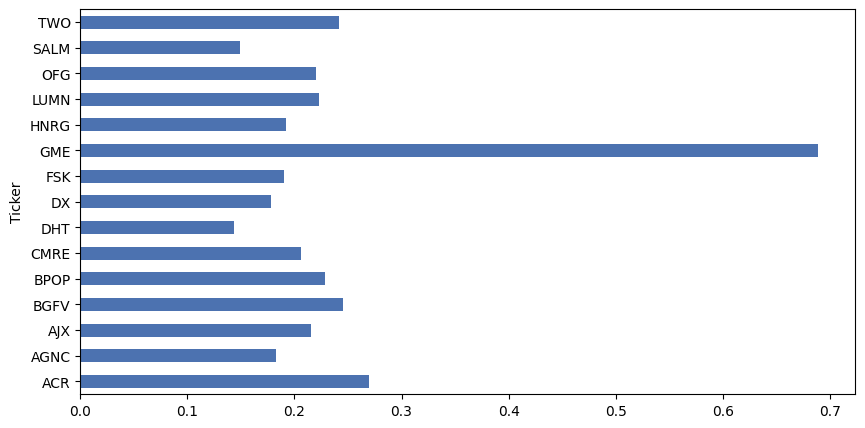

In [19]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior
market_prior.plot.barh(figsize=(10,5));

**implied returns have been established**

**Now we need to input our predictions and confidence levels for ESG and Value.**

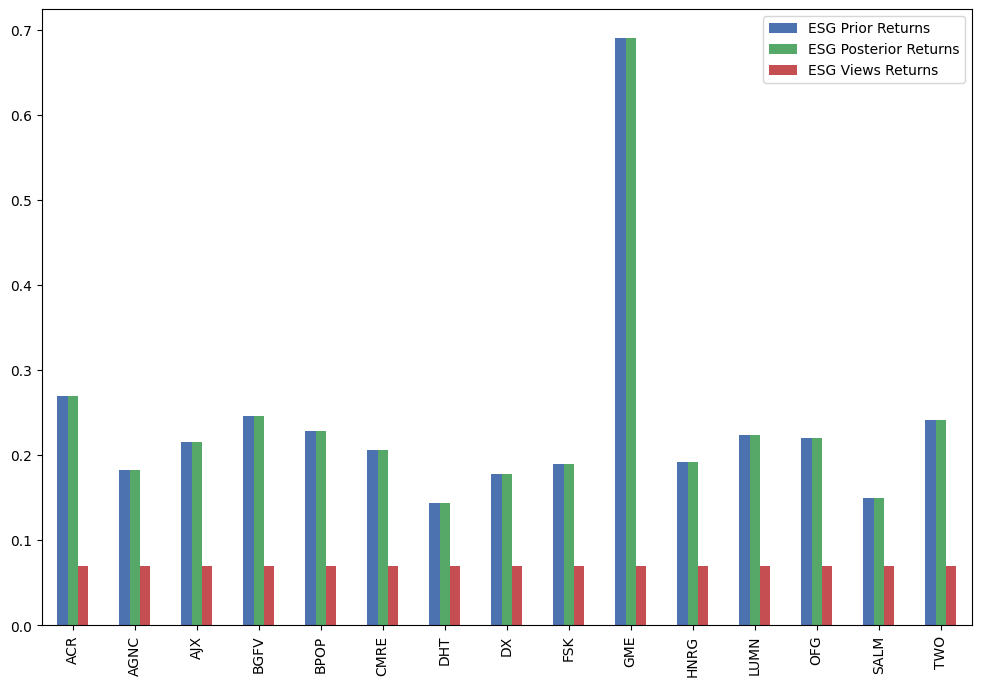

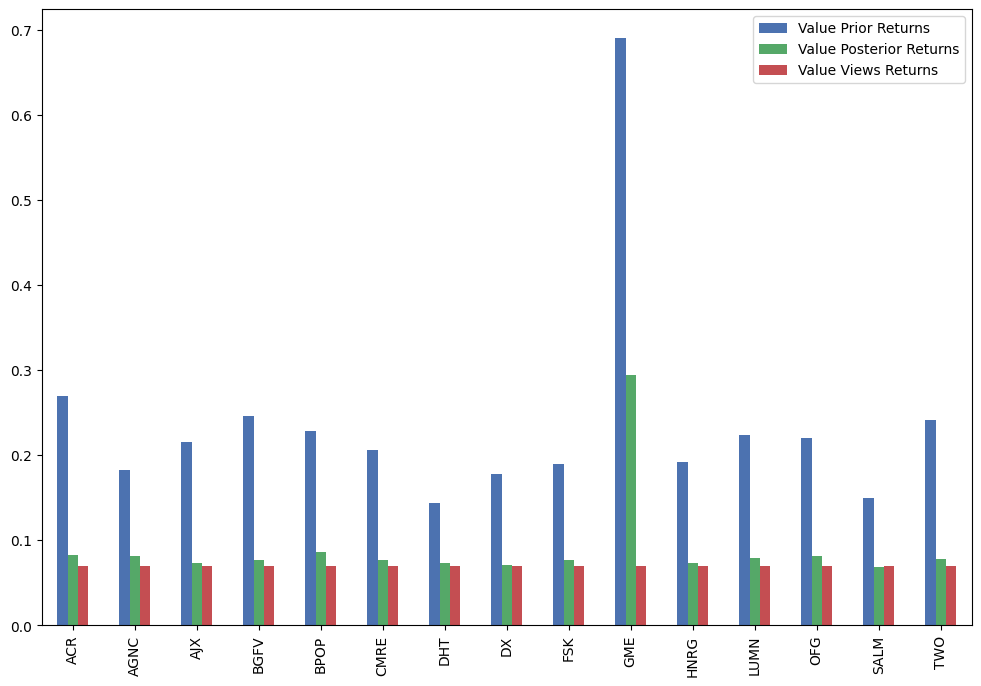

In [20]:
ESG_viewdict = {
    "TWO": 0.07,
    "FSK": 0.07,
    "AJX": 0.07,
    "OFG": 0.07,
    "CMRE": 0.07,
    "HNRG": 0.07,
    "SALM": 0.07,
    "DHT": 0.07,
    "AGNC": 0.07,
    "BGFV": 0.07,
    "ACR": 0.07,
    "GME": 0.07,
    "BPOP": 0.07,
    "LUMN": 0.07,
    "DX": 0.07,
}


Value_viewdict = {
    "TWO": 0.07,
    "FSK": 0.07,
    "AJX": 0.07,
    "OFG": 0.07,
    "CMRE": 0.07,
    "HNRG": 0.07,
    "SALM": 0.07,
    "DHT": 0.07,
    "AGNC": 0.07,
    "BGFV": 0.07,
    "ACR": 0.07,
    "GME": 0.07,
    "BPOP": 0.07,
    "LUMN": 0.07,
    "DX": 0.07,
}

ESG_confidences = [
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
]
Value_confidences=[
    0.869900235,
    0.847441942,
    0.765099906,
    0.647090013,
    0.79514088,
    0.755602945,
    0.725069595,
    0.737265181,
    0.682530357,
    0.805508352,
    0.654820673,
    0.552808257,
    0.766661599,
    0.825511131,
    0.749187252,
]

def BL_Plot(viewdict, confidences,title):
  bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)
  # Posterior estimate of returns
  ret_bl = bl.bl_returns()
  ret_bl
  rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
              index=[f"{title} Prior Returns", f"{title} Posterior Returns", f"{title} Views Returns"]).T
  rets_df
  rets_df.plot.bar(figsize=(12,8));

BL_Plot(ESG_viewdict, ESG_confidences,title="ESG")
BL_Plot(Value_viewdict, Value_confidences,title="Value")


**We now combine our views.**

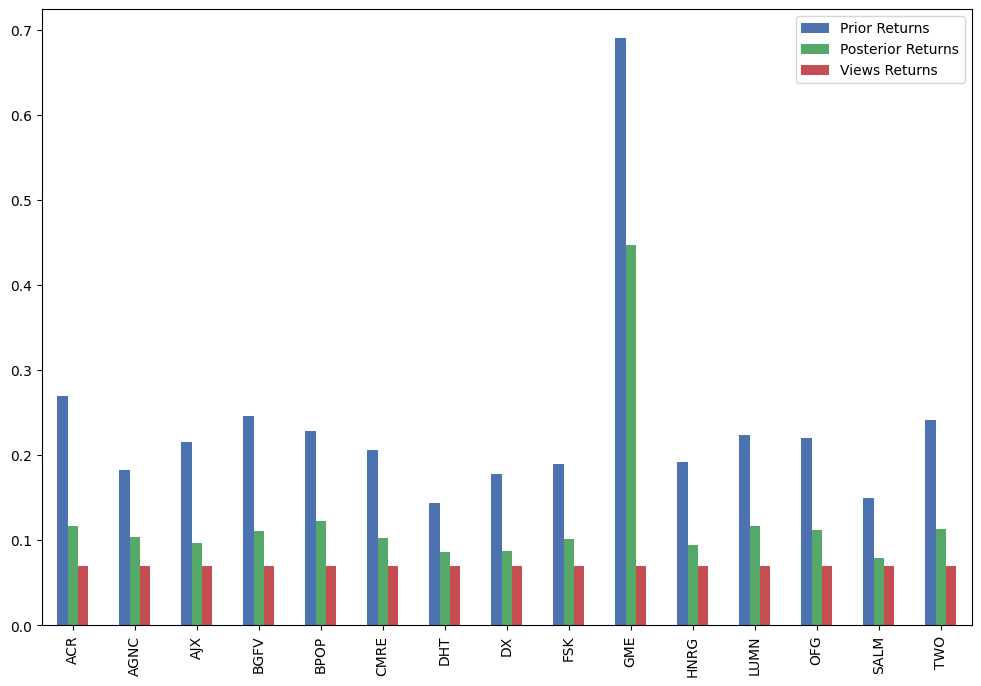

In [21]:
confidences= [(esg + value) / 2 for esg, value in zip(ESG_confidences, Value_confidences)] #average our confidences
viewdict = {key: (ESG_viewdict[key] + Value_viewdict[key]) / 2 for key in ESG_viewdict} #average the two views


bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior Returns", "Posterior Returns", "Views Returns"]).T
rets_df
rets_df.plot.bar(figsize=(12,8));

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Text(0.5, 1.0, 'Portfolio Weights')

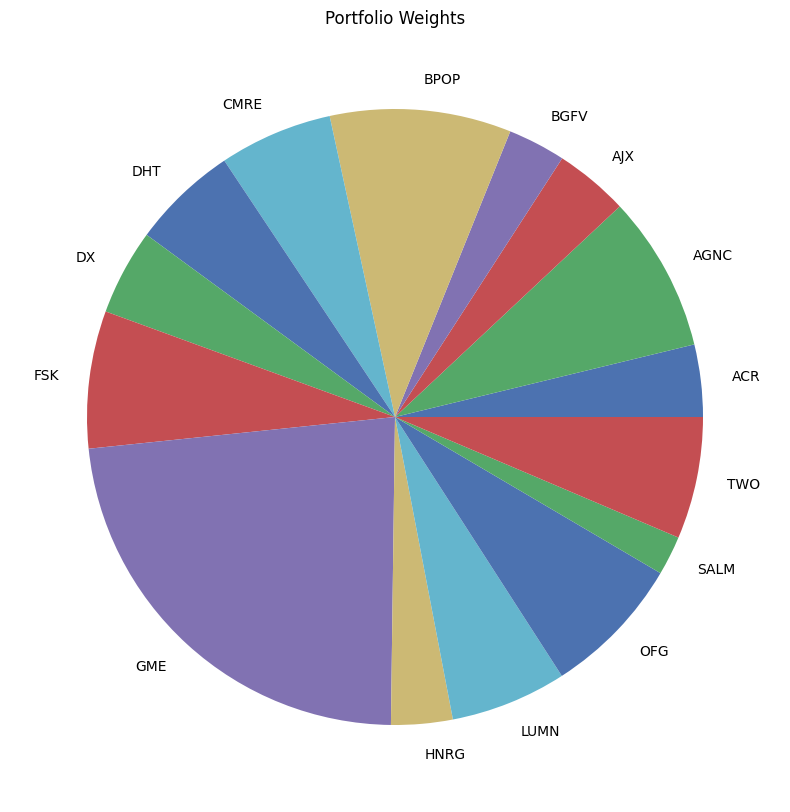

In [22]:
from pypfopt import EfficientFrontier, objective_functions
S_bl = bl.bl_cov()
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
ef = ef.clean_weights()
weights
pd.Series(weights).plot.pie(figsize=(10,10));
plt.title('Portfolio Weights')

Expected annual return: 18.5%
Annual volatility: 41.1%
Sharpe Ratio: 0.40


/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.18452537569770325, 0.41130608394332807, 0.4000071531165886)

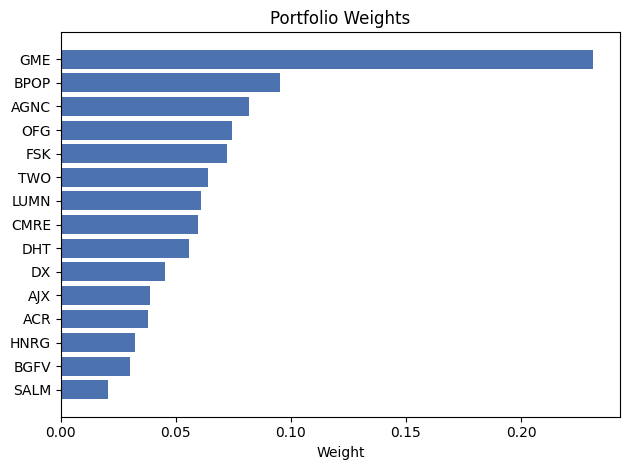

In [23]:
from pypfopt.plotting import plot_weights
plt.title('Portfolio Weights')
plot_weights(weights)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)

In [30]:

for key in weights:
    weights[key] *= 100

weights

OrderedDict([('ACR', 3.788),
             ('AGNC', 8.195),
             ('AJX', 3.8850000000000002),
             ('BGFV', 3.0269999999999997),
             ('BPOP', 9.51),
             ('CMRE', 5.945),
             ('DHT', 5.579),
             ('DX', 4.506),
             ('FSK', 7.2090000000000005),
             ('GME', 23.146),
             ('HNRG', 3.2230000000000003),
             ('LUMN', 6.099),
             ('OFG', 7.426000000000001),
             ('SALM', 2.062),
             ('TWO', 6.401)])